# Spatial Taylor Expansion
Instead of computing the term-by-term Taylor Expansion for pCO$_{2}$ over the whole region, we now move on to compute the Taylor Expansion for each grid cell in the region. This is similar to the spatial plots we made for spatial correlations. Hopefully it can give us an idea of the patterns that may emerge in a given region. The goal is to make this into a standalone .py script.

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.basemap import Basemap

# CalCS Practice


In [2]:
def create_term(ds, var):
    """
    Input the post-regression spatial dataset and a variable name. This will return a DataArray that has
    computed the taylor expansion term value and has named the DataArray properly.
    """
    term = ds['sens_' + var] * ds[var + '_slopes']
    term.name = var + '_term'
    return term

In [9]:
fileDir = '/glade/u/home/rbrady/projects/EBUS_BGC_Variability/data/processed/calcs/pco2_taylor_spatial/calcs-pco2-taylor-spatial-vs-nino34-smoothed-pRemoved.nc'
ds = xr.open_dataset(fileDir)

In [10]:
# Term-by-term Taylor Expansion
dic_term = create_term(ds, 'DIC')
alk_term = create_term(ds, 'ALK')
sst_term = create_term(ds, 'SST')
salt_term = create_term(ds, 'SALT')

# Total terms
approx_total = dic_term + alk_term + sst_term + salt_term
approx_total.name = 'approx_total'
model_total = ds['pCO2SURF_slopes']
model_total.name = 'model_total'

# Only include grid cells where every term has p < 0.05
conditions = (~np.isnan(dic_term)) & (~np.isnan(alk_term)) & \
             (~np.isnan(sst_term)) & (~np.isnan(salt_term))

# Create new datset for these.
taylor_expansion = xr.merge([dic_term, alk_term, sst_term, salt_term, approx_total, model_total])
taylor_expansion = taylor_expansion.where(conditions)

# Visualization Functions

In [40]:
def visual_bounds(EBU):
    if EBU == "CalCS":
        lat1 = 34
        lat2 = 46
        lon1 = -133
        lon2 = -110
    elif EBU == 'HumCS':
        lat1 = -20
        lat2 = -2
        lon1 = -90
        lon2 = -70
    elif EBU == 'CanCS':
        lat1 = 10
        lat2 = 28
        lon1 = -25
        lon2 = -10
    elif EBU == 'BenCS':
        lat1 = -35
        lat2 = -15
        lon1 = 5
        lon2 = 20
    return lat1,lat2,lon1,lon2

In [38]:
def setup_map(ax, lat1, lat2, lon1, lon2):
    m = Basemap(projection='merc',
                lat_0=(lat1+lat2)/2,
                lon_0=(lon1+lon2)/2,
                llcrnrlon=lon1,
                urcrnrlon=lon2,
                llcrnrlat=lat1,
                urcrnrlat=lat2,
                fix_aspect=False,
                resolution='i')
    m.drawcoastlines(color='#D3D3D3')
    #m.drawcountries()
    #m.drawstates()
    m.fillcontinents(color='#D3D3D3')
    m.drawmapboundary(fill_color='white')
    m.drawparallels(np.arange(lat1, lat2+1, 3),
                   labels=[False,False,False,False], size=20,
                   color='w')
    m.drawmeridians(np.arange(lon1, lon2+1, 3),
                   labels=[False, False, False, False], size='x-large',
                   color='w')
    return m

# Visualization

In [57]:
def map_term(ax, data_term, EBU):
    lat1,lat2,lon1,lon2 = visual_bounds('CalCS')
    m = setup_map(ax1, lat1, lat2, lon1, lon2)
    data = taylor_expansion[data_term].mean(dim='ensemble').values
    data = np.ma.array(data, mask=np.isnan(data))
    m.pcolormesh(lon-360, lat, data, latlon=True,
                 vmin=-10, vmax=10, cmap='RdBu_r')
    plt.title(data_term)
    return m

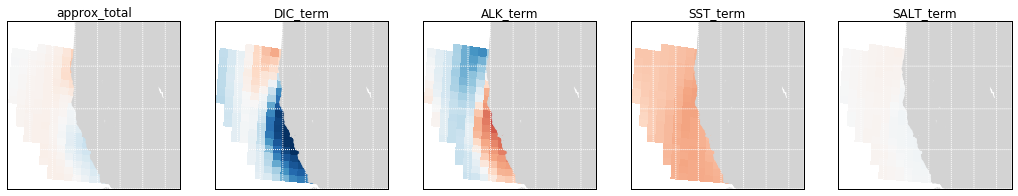

In [58]:
# ADD VARIANCE ON BOTTOM.
lon = taylor_expansion['TLONG'].values
lat = taylor_expansion['TLAT'].values

fig = plt.figure(figsize=(18,3))
ax1 = fig.add_subplot(151)
m = map_term(m, 'approx_total', 'CalCS')
ax2 = fig.add_subplot(152)
m = map_term(m, 'DIC_term', 'CalCS')
ax3 = fig.add_subplot(153)
m = map_term(m, 'ALK_term', 'CalCS')
ax4 = fig.add_subplot(154)
m = map_term(m, 'SST_term', 'CalCS')
ax5 = fig.add_subplot(155)
m = map_term(m, 'SALT_term', 'CalCS')